In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats
import plotly.express as px
import matplotlib.ticker as ticker

sns.set_style('whitegrid')

import plotly.io as pio
pio.renderers.default = "png"

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from functions import missing_data_df, impute_null, modify_features, encode_ordinal, dummify_features

pd.set_option('display.max_columns', None)

## Loading the data

In [2]:
# Load the data
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

df = df[df.SaleCondition == 'Normal']
df = df[~df.MSZoning.isin(['C (all)', 'I (all)', 'A (all)', 'A (agr)'])] # not residential

df shape: (2580, 80)


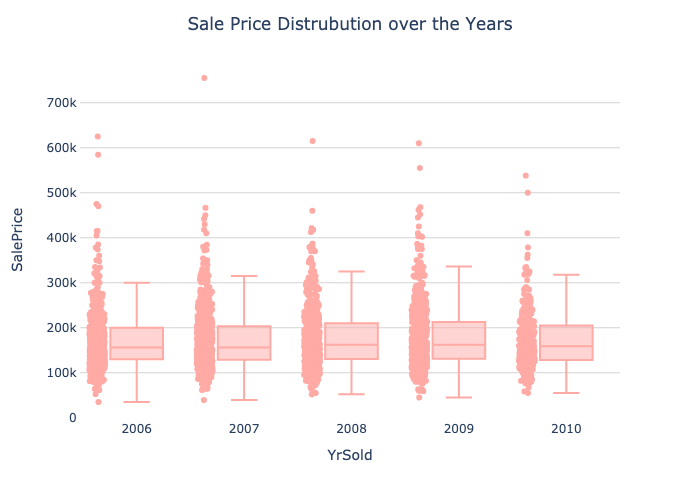

In [3]:
# Sale Price distribution for each year
fig = px.box(
            df, 
            x='YrSold', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(title='Sale Price Distrubution over the Years', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

In [4]:
# Save 2010 data for predicting
print(df.YrSold.value_counts(normalize=True))

# We'll perform EDA only on the training set so the test set can give us an unbiased estimate of the error. 
df_2010 = df[df['YrSold']==2010].reset_index(drop=True)
df = df[df['YrSold']<2010].reset_index(drop=True)

2009    0.232694
2007    0.230192
2008    0.219766
2006    0.191827
2010    0.125521
Name: YrSold, dtype: float64


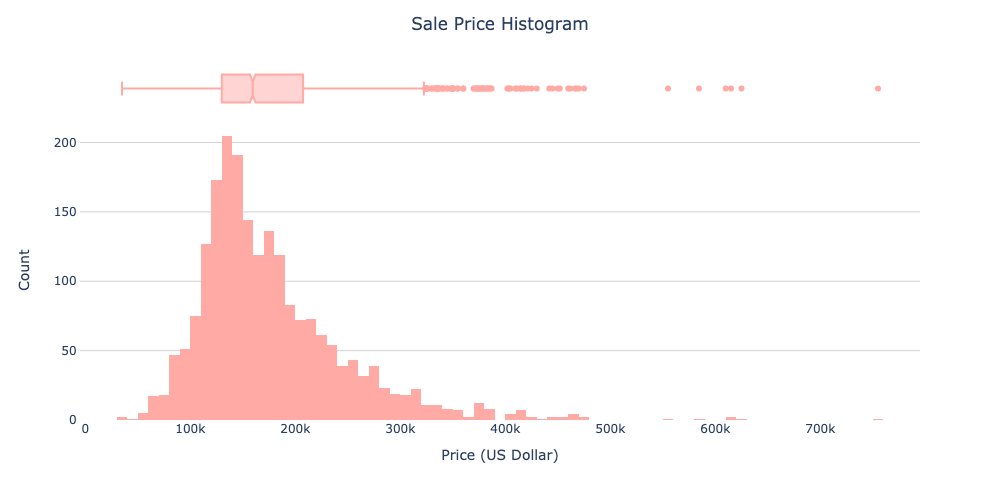

In [5]:
# We plot the target variable

fig = px.histogram(
                df, 
                x="SalePrice",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(
                title='Sale Price Histogram', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Price (US Dollar)",
                row=1, col=1)

fig.show()

## Missing data

In [6]:
# Check for missing values
missing_data_df(df)

,Count,Percent
PoolQC,2088,99.570815
MiscFeature,2022,96.423462
Alley,1961,93.514545
Fence,1664,79.351454
FireplaceQu,988,47.114926
LotFrontage,403,19.217930
GarageYrBlt,93,4.434907
GarageFinish,93,4.434907
GarageQual,93,4.434907
GarageCond,93,4.434907


In [7]:
# We will drop the PoolQC and PoolArea features since more that 99% of houses don't have a pool.
df.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

### Imputing null values

In [8]:
# LotFrontage

temp = df[~df['LotFrontage'].isna()]

print(temp.LotFrontage.describe())
temp.groupby(['LotConfig']).agg({'LotFrontage':['median', 'count']}).sort_values(by=('LotFrontage', 'median'))


count    1694.000000
mean       68.184179
std        22.671184
min        21.000000
25%        57.000000
50%        67.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


LotFrontage      
               median count
LotConfig                  
CulDSac          47.5    60
FR2              60.0    44
FR3              62.0     9
Inside           65.0  1315
Corner           80.0   266

We have different types of null values:
- On numerical variables where N/A means no feature we will impute with 0.
- On categorical variables where N/A means no feature we will impute with 'None'.
- The remaining features with N/A values will be imputed as followed:
    - For GarageYrBlt we'll useh YearBuilt.
    - For Electrical we'll use the mode.
    - For MasVnrType we'll impute with 'None'.
    - For MasVnrArea we'll impute with 0.
    - For LotFrontage we'll impute with the median given the LotConfig variable.

In [9]:
df = impute_null(df)
df_2010 = impute_null(df_2010)

## EDA

##### Numerical Features:

`['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']`

##### Discrete Features:

`['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                     'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSSubClass']`

##### Nominal Features:

`['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
                    'GarageType', 'SaleType']`

##### Ordinal Features:

`['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'OverallQual', 'OverallCond']`

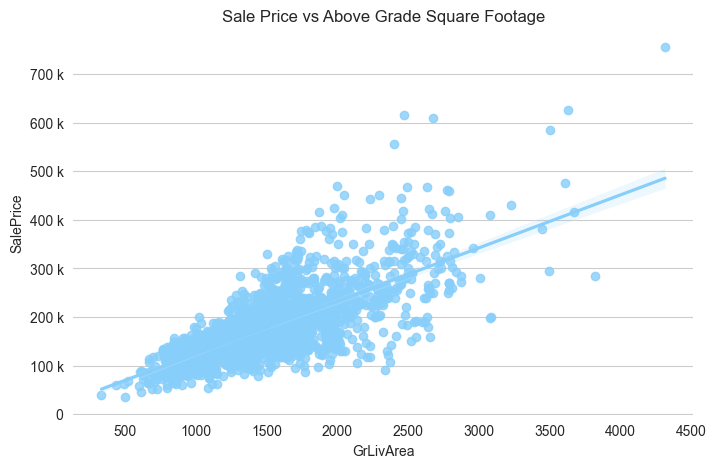

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine(left=True, bottom=True)

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax, color='#87CEFA') 
ax.set_title('Sale Price vs Above Grade Square Footage')
ax.xaxis.grid(False)

ax.yaxis.set_major_formatter(ticker.EngFormatter())

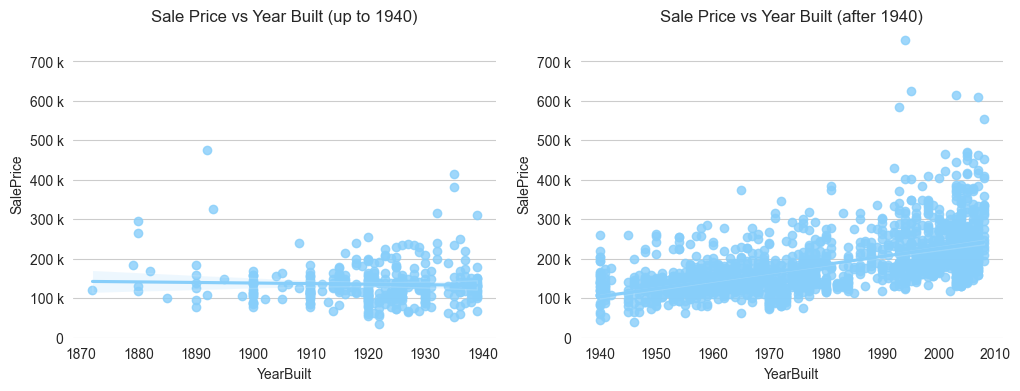

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)
YrCut=1940

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']<YrCut], ax=ax[0], color='#87CEFA') 

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']>=YrCut], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs Year Built (up to 1940)')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs Year Built (after 1940)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

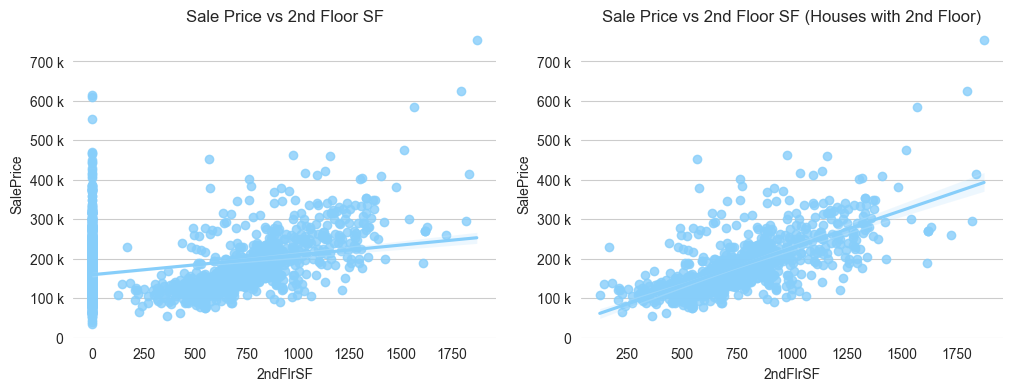

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

sns.regplot(x="2ndFlrSF", y="SalePrice", data=df, ax=ax[0], color='#87CEFA') 

sns.regplot(x="2ndFlrSF", y="SalePrice", data=df[df['2ndFlrSF']>0], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs 2nd Floor SF')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs 2nd Floor SF (Houses with 2nd Floor)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

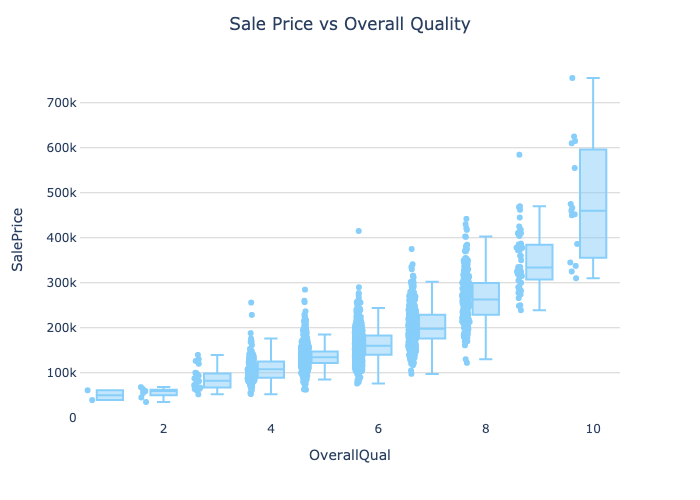

In [13]:
# Sale Price distribution for each year
order = df.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='OverallQual', 
            y="SalePrice", 
            points="all",
            category_orders={'OverallQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs Overall Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

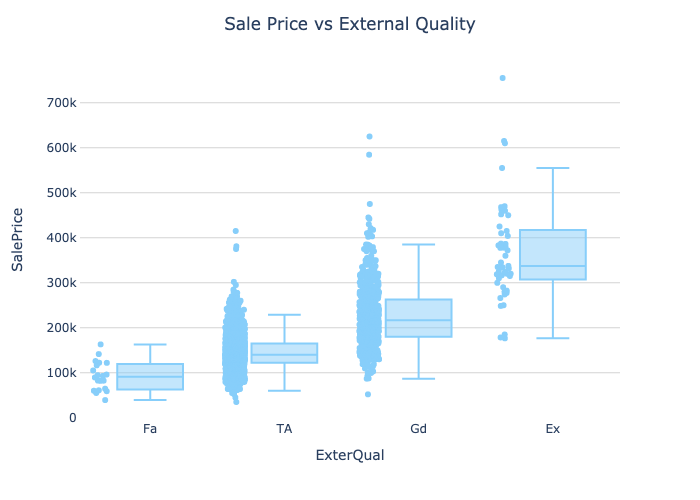

In [14]:
# Sale Price distribution for each year
order = df.groupby('ExterQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='ExterQual', 
            y="SalePrice", 
            points="all",
            category_orders={'ExterQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

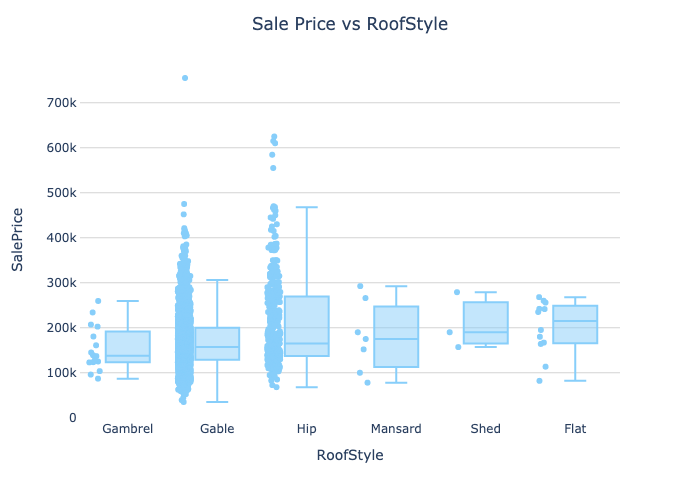

In [15]:
# Sale Price distribution for each year
order = df.groupby('RoofStyle').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='RoofStyle', 
            y="SalePrice", 
            points="all",
            category_orders={'RoofStyle':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs RoofStyle', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

## Feature Engineering

In [16]:
# Create HouseAge and RemodAge feature.
# Merge underpopulated categories
# Binarize features where only a few categories appear to be correlated to SalesPrice.
# Create a Location features
df = modify_features(df)
df_2010 = modify_features(df_2010)

In [17]:
# Encode ordinal features into numbers.
df = encode_ordinal(df)
df_2010 = encode_ordinal(df_2010)

In [18]:
# Dummies Location and BldgType features
df = dummify_features(df)
df_2010 = dummify_features(df_2010)


# Model

In [19]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', '2ndFlrSF', 'OverallCond', 
                    'Fireplaces', 'LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location_2', 'Location_3', 'Location_4',
                    'CulDSac', 'Exterior1st_top']
                        

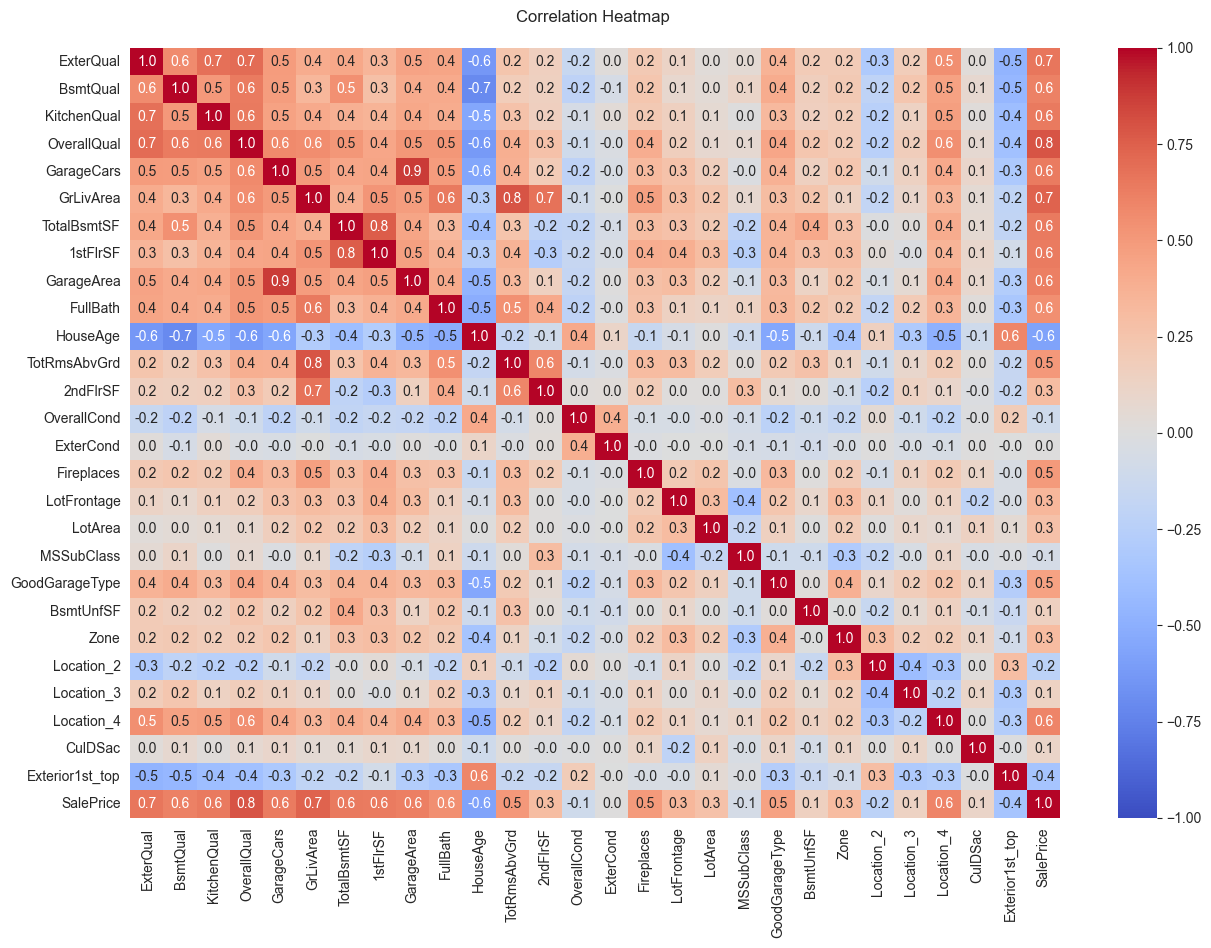

In [20]:
plt.figure(figsize=(15, 10))

corr_mat = df[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [21]:
df = df.reset_index(drop=True)
df_2010 = df_2010.reset_index(drop=True)

scaler = StandardScaler()

X_train = df[feature_selection]
y_train = np.log(df['SalePrice'])

X_test= df_2010[feature_selection]
y_test = np.log(df_2010['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Linear Regression

In [22]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9272 0.9211 0.924  0.9299 0.9342]
Mean shuffled cross validation score: 0.9273
RMSE Shuffled cross validation score: [0.1039 0.1055 0.0945 0.1    0.0911]
RMSE Mean shuffled cross validation score: 0.099


In [23]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9177
RMSE Test score: 0.1025


In [24]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17489.157574033918
17790.440537349


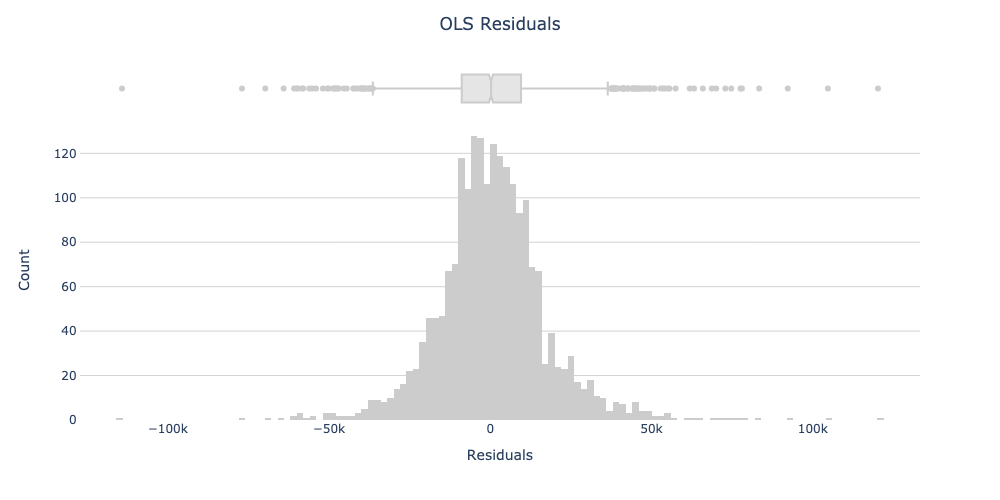

In [25]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

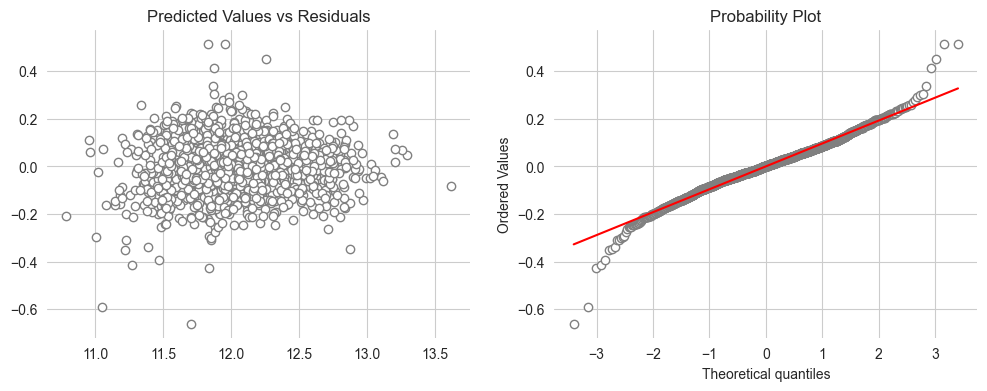

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [27]:
res = stats.shapiro(residuals)
res.statistic

0.9750702381134033

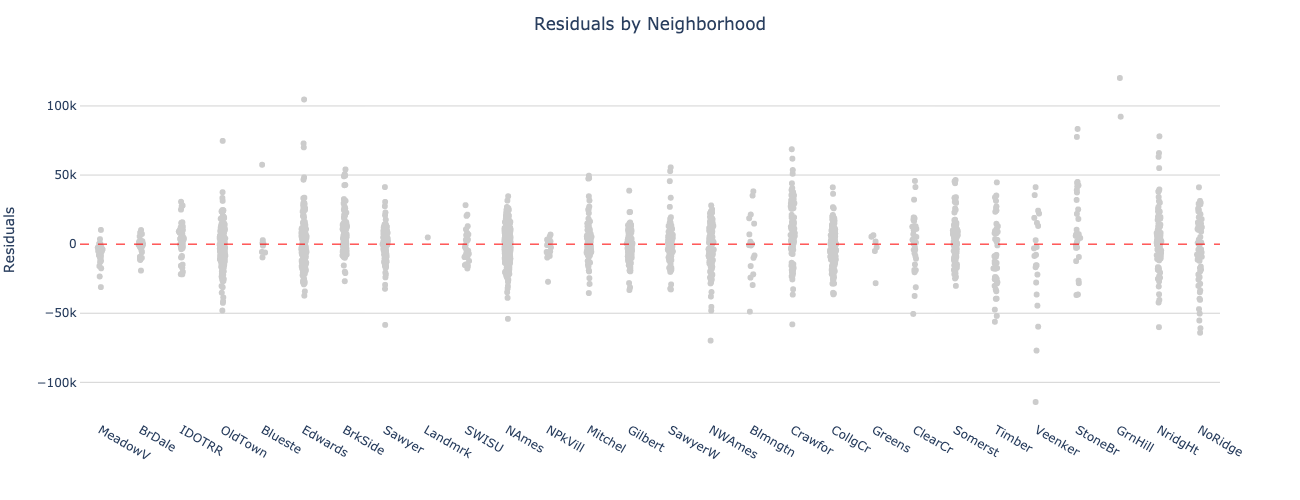

In [28]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

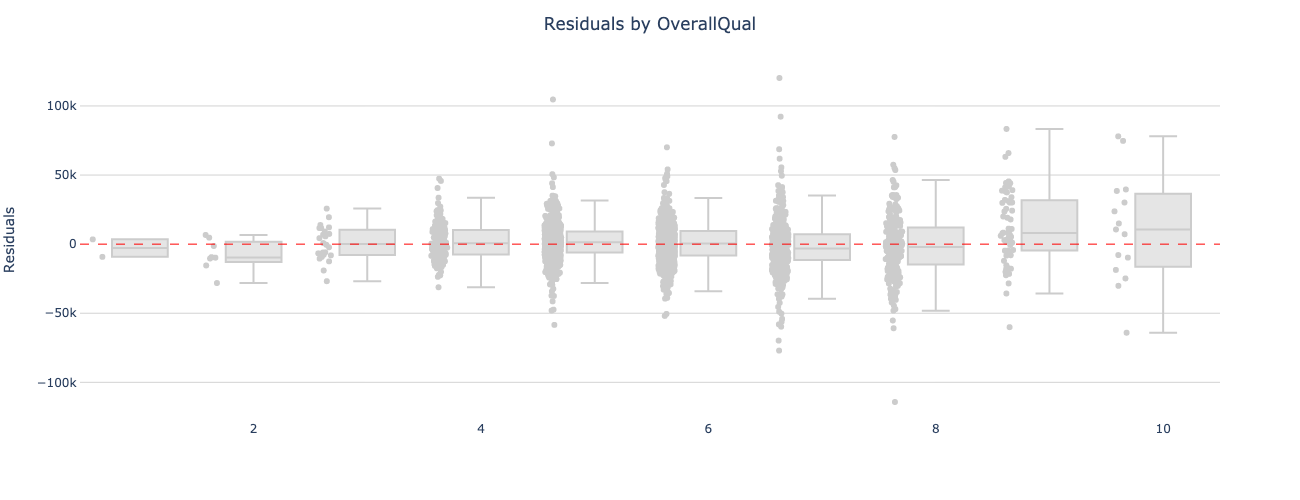

In [29]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

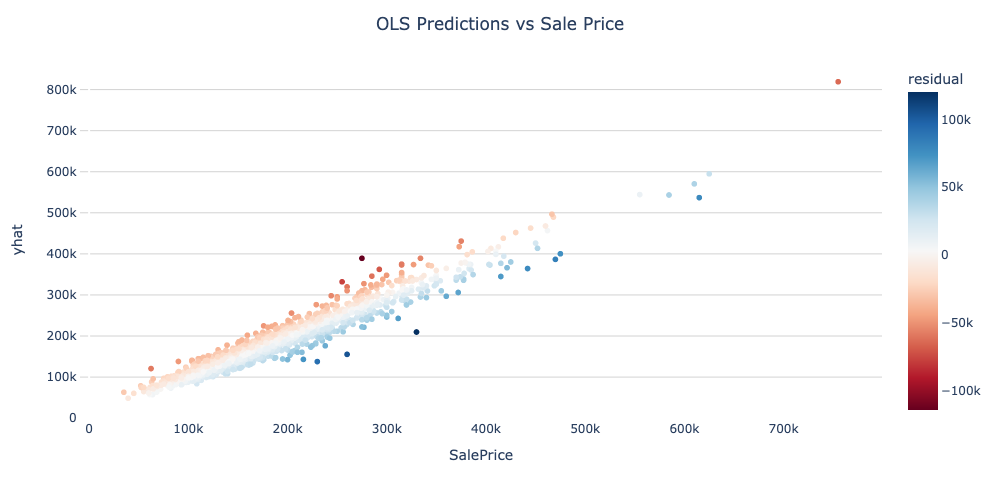

In [30]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [31]:
lasso = LassoCV(cv=3)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


Best alpha: 0.0002994042737628344
RMSE: 0.10237542537603231


In [32]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9274 0.9204 0.924  0.9298 0.9341]
Mean shuffled cross validation score: 0.9271
RMSE Shuffled cross validation score: [0.1038 0.106  0.0945 0.1    0.0911]
RMSE Mean shuffled cross validation score: 0.0991


In [33]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17464.162517364246
17782.040962890645


In [34]:
X_train_prov = X_train_scaled.copy()
X_train_prov['SalePrice'] = y_train
X_train_prov = X_train_prov[(df['OverallQual']>7)].reset_index(drop=True)

X_test_prov = X_test_scaled.copy()
X_test_prov['SalePrice'] = y_test
X_test_prov = X_test_prov[ (df_2010['OverallQual']>7)].reset_index(drop=True)


yhat_train = lasso.predict(X_train_prov.drop(columns='SalePrice'))
yhat_test = lasso.predict(X_test_prov.drop(columns='SalePrice'))

train_mse_non_log = mean_squared_error(np.exp(X_train_prov['SalePrice']), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(X_test_prov['SalePrice']), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

25405.335209096433
24928.979080328667


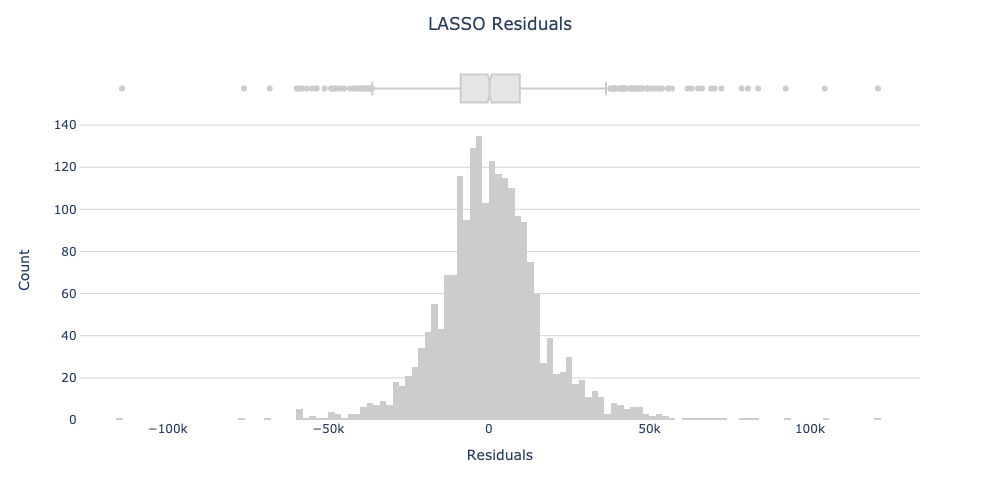

In [35]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

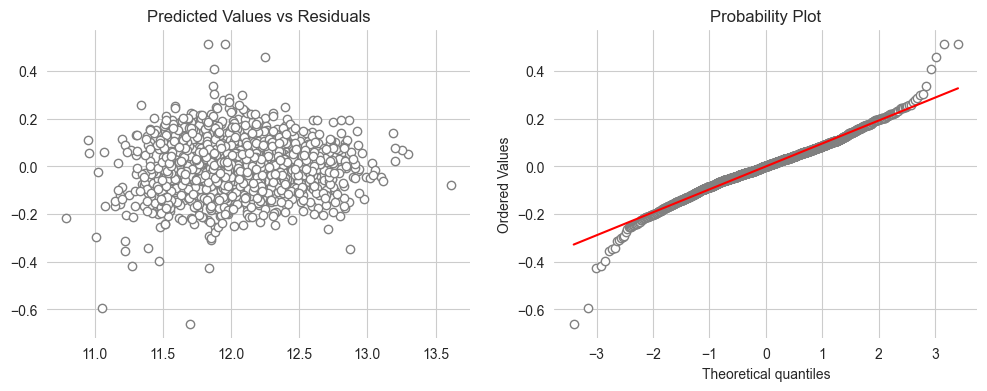

In [36]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [37]:
res = stats.shapiro(residuals)
res.statistic

0.9747341275215149

## Ridge

In [38]:
ridge = RidgeCV(cv=3)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)


Best alpha: 10.0
RMSE: 0.10239508001795575


In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9273 0.9213 0.924  0.9298 0.9344]
Mean shuffled cross validation score: 0.9274
RMSE Shuffled cross validation score: [0.1038 0.1054 0.0945 0.1001 0.091 ]
RMSE Mean shuffled cross validation score: 0.0989


In [40]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_mse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

17470.639435231093
17774.32415004275


In [41]:
X_train_prov = X_train_scaled.copy()
X_train_prov['SalePrice'] = y_train
X_train_prov = X_train_prov[(df['OverallQual']>7)].reset_index(drop=True)

X_test_prov = X_test_scaled.copy()
X_test_prov['SalePrice'] = y_test
X_test_prov = X_test_prov[ (df_2010['OverallQual']>7)].reset_index(drop=True)


yhat_train = ridge.predict(X_train_prov.drop(columns='SalePrice'))
yhat_test = ridge.predict(X_test_prov.drop(columns='SalePrice'))

train_mse_non_log = mean_squared_error(np.exp(X_train_prov['SalePrice']), np.exp(yhat_train), squared=False)
test_mse_non_log = mean_squared_error(np.exp(X_test_prov['SalePrice']), np.exp(yhat_test), squared=False)

print(train_mse_non_log)
print(test_mse_non_log)

25422.10778940819
24900.10061330078


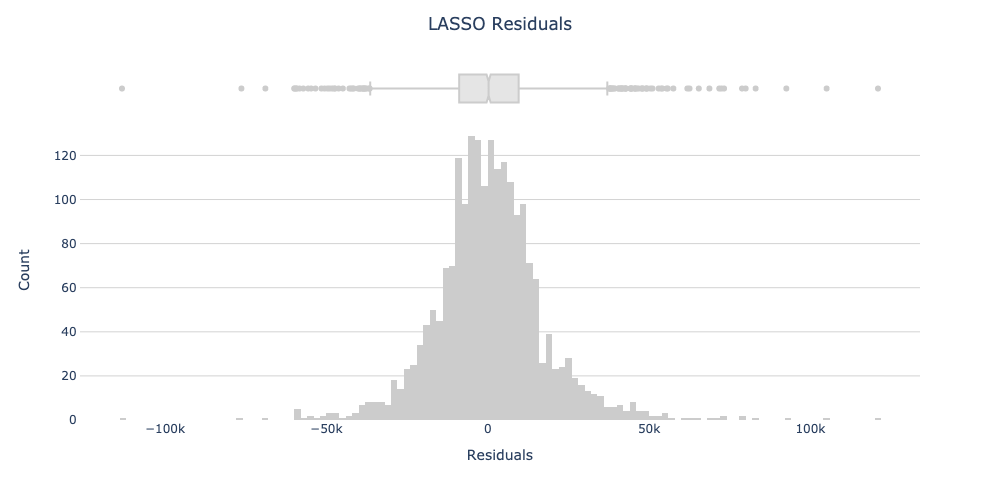

In [42]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                df, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

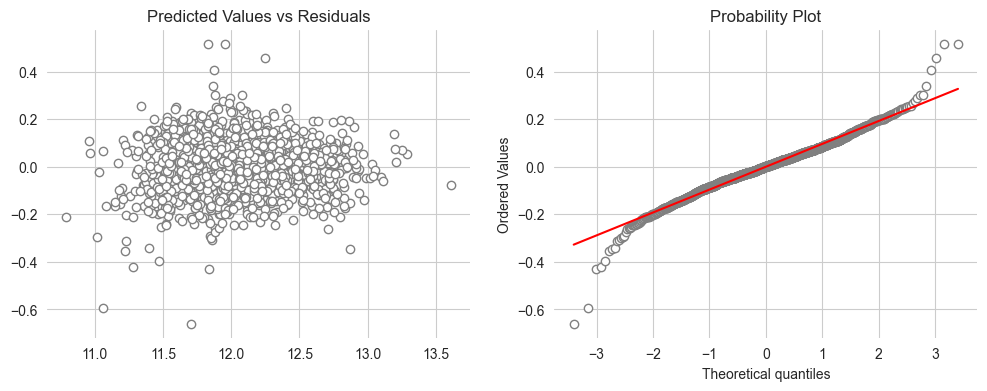

In [43]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [44]:
res = stats.shapiro(residuals)
res.statistic

0.9746389985084534